In [1]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self,**kwargs):
        self.step_n = 0
        return self.env.reset(**kwargs)


    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            terminated = True

        return state, reward, terminated, truncated, info


env = MyWrapper()

env.reset()


(array([ 0.03653317, -0.00187937, -0.02338587,  0.00402136], dtype=float32),
 {})

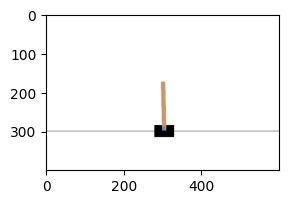

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state, probs = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info  = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', terminated)
    print('probs=',probs)


test_env()

env.observation_space= Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space= Discrete(2)
state= [-0.01347326 -0.00353876 -0.04355745  0.02381279]
action= 1
next_state= [-0.01354404  0.1921799  -0.04308119 -0.28228858]
reward= 1.0
done= False
probs= {}


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
).to(device)

#经验网络,用于评估一个状态的分数
target_model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
).to(device)

#把model的参数复制给next_model
target_model.load_state_dict(model.state_dict())

model, target_model

c:\Users\13306\anaconda3\envs\SB3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ))

In [5]:
import random


#得到一个动作
def get_action(state):
    if random.random() < 0.01:
        return random.choice([0, 1])

    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 4).to(device) #batch_size, state_size

    #print(model(state))
    #print(model(state).argmax())
    #print(model(state).argmax().item()) # o or 1, indicates the best action

    return model(state).argmax().item() # forward, return the max q and the action


get_action([0.0013847, -0.01194451, 0.04260966, 0.00688801])

0

## 使用 CUDA buffer

In [34]:
#制造样本池。 这里没有用到cuda，所以不使用了
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 199:
        #初始化游戏
        state, _ = env.reset()
        # print(state)

        #玩到游戏结束为止
        terminated = False
        while not terminated:
            #根据当前状态得到一个动作
            action = get_action(state)


            #执行动作,得到反馈
            next_state, reward, terminated, truncated, info = env.step(action)
            # print(next_state, reward, terminated, truncated, info )

            #记录数据样本
            datas.append((state, action, reward, next_state, terminated))

            #更新游戏状态,开始下一个动作
            state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 1_0000:
        datas.pop(0)


update_data()
len(datas)

303

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中64个采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4).to(device)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1).to(device)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1).to(device)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4).to(device)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1).to(device)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state.size(), action.reshape(1,-1), reward.reshape(1,-1), next_state.size(), over.reshape(1,-1)

C:\Users\13306\AppData\Local\Temp\ipykernel_60336\3070215748.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4).to(device)


(torch.Size([64, 4]),
 tensor([[0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
          1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
          1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0]], device='cuda:0'),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0'),
 torch.Size([64, 4]),
 tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'))

In [8]:
def get_qvalue(state, action):
    #使用状态计算出动作的logits
    #[b, 4] -> [b, 2]
    # print(state, action)
    value = model(state) # action is already obtained by forward calculation via model(state).argmax().item()
    # print(value)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 2] -> [b, 1]
    value = value.gather(dim=1, index=action) # the action is the best one in current state
    # print(value) # best q

    return value # q value


get_qvalue(state, action) # 64 samples, action space 0 and 1

tensor([[0.0385],
        [0.0750],
        [0.0379],
        [0.1247],
        [0.0277],
        [0.0720],
        [0.0932],
        [0.1174],
        [0.0302],
        [0.0313],
        [0.1478],
        [0.0341],
        [0.1269],
        [0.0319],
        [0.0401],
        [0.0362],
        [0.0794],
        [0.0622],
        [0.0360],
        [0.1329],
        [0.0318],
        [0.0383],
        [0.0312],
        [0.0382],
        [0.0895],
        [0.0296],
        [0.0896],
        [0.0333],
        [0.0625],
        [0.0368],
        [0.0552],
        [0.0779],
        [0.0353],
        [0.0526],
        [0.0331],
        [0.0252],
        [0.0311],
        [0.0380],
        [0.0404],
        [0.0364],
        [0.0406],
        [0.0307],
        [0.0371],
        [0.0858],
        [0.0988],
        [0.1372],
        [0.0416],
        [0.1116],
        [0.0281],
        [0.0400],
        [0.0651],
        [0.0334],
        [0.0366],
        [0.0490],
        [0.0583],
        [0

In [37]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了, i.e., q value
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 4] -> [b, 2]
    with torch.no_grad():
        target = target_model(next_state) # return the q value and action
    #print(target)
    #取所有动作中分数最大的
    #[b, 2] -> [b, 1]
    #print(target.max(dim=1),target.max(dim=1)[0])
    target = target.max(dim=1)[0] # the max q value
    target_next_action = target.max(dim=1)[1] # the max q value
    target = target.reshape(-1, 1) # (64, 1) batch_size:64

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[21.3020, 27.3173],
        [49.3474, 49.1575],
        [15.1400, 21.8596],
        [43.1486, 45.7153],
        [44.5409, 47.4569],
        [38.6912, 41.8864],
        [38.2400, 41.8224],
        [26.8617, 32.1503],
        [43.4888, 45.2425],
        [35.4382, 40.0791],
        [28.0833, 33.5425],
        [32.6366, 38.3292],
        [33.3827, 38.1785],
        [25.7422, 31.8381],
        [47.5144, 49.3074],
        [42.4028, 45.3046],
        [49.0607, 49.5487],
        [40.7599, 43.3117],
        [14.9178, 21.7229],
        [15.1952, 21.2612],
        [39.0250, 42.7838],
        [44.9190, 47.1404],
        [47.4434, 48.5534],
        [44.2308, 46.3658],
        [22.1296, 27.3422],
        [46.6276, 47.8598],
        [37.5428, 41.1468],
        [37.8998, 41.9264],
        [23.7313, 28.4206],
        [16.0343, 22.9589],
        [46.7782, 48.2425],
        [22.2966, 27.4004],
        [35.6870, 40.1811],
        [28.1739, 32.6828],
        [31.8566, 37.2615],
        [47.9610, 49

tensor([[27.7710],
        [49.3605],
        [ 1.0000],
        [45.8010],
        [47.5078],
        [42.0487],
        [41.9860],
        [32.5073],
        [45.3377],
        [40.2775],
        [33.8716],
        [38.5626],
        [38.4150],
        [32.2014],
        [49.3212],
        [45.3985],
        [49.5577],
        [43.4455],
        [22.2885],
        [ 1.0000],
        [42.9281],
        [47.1976],
        [48.5823],
        [46.4385],
        [27.7954],
        [47.9026],
        [41.3238],
        [42.0879],
        [28.8522],
        [23.4998],
        [48.2777],
        [27.8524],
        [40.3775],
        [33.0291],
        [37.5162],
        [49.5332],
        [30.2630],
        [49.5580],
        [48.2416],
        [22.7308],
        [35.3144],
        [36.9160],
        [47.2173],
        [49.2357],
        [28.9693],
        [42.8325],
        [47.2075],
        [35.6424],
        [49.2288],
        [48.4537],
        [46.9098],
        [37.8622],
        [47.

In [10]:
from IPython import display


def test(play=False):
    state,_ = env.reset()
    reward_sum = 0
    terminated = False
    while not terminated:
        action = get_action(state)
        state, reward, terminated, truncated, info  = env.step(action)
        reward_sum += reward

        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

22.3

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(400):
        #更新N条数据
        update_data()

        #每次更新过数据后,每次64个sample,学习100次
        for i in range(100):
            #采样一批数据
            state, action, reward, next_state, over = get_sample() # 64个sample

            #计算一批样本的value和target
            value = get_qvalue(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model every 10 steps
            if (i + 1) % 10 == 0:
                target_model.load_state_dict(model.state_dict())

        if epoch % 50 == 0:
            print(epoch, len(datas), sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/4.DQN_CartPole')


train()

0 429 9.8
50 10000 138.8
100 10000 161.4
150 10000 196.4
200 10000 200.0
250 10000 172.0
300 10000 184.4
350 10000 188.0


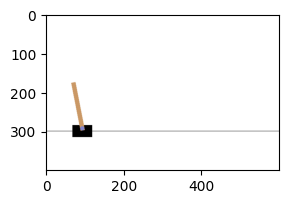

200.0

In [31]:
model = torch.load('save/4.DQN_CartPole')

test(play=True)